Found 480 images for train subset
Found 120 images for test subset
Training samples: 480
Testing samples: 120
Image batch shape: torch.Size([4, 3, 256, 256])
Heatmap batch shape: torch.Size([4, 68, 64, 64])
Landmarks batch shape: torch.Size([4, 68, 2])


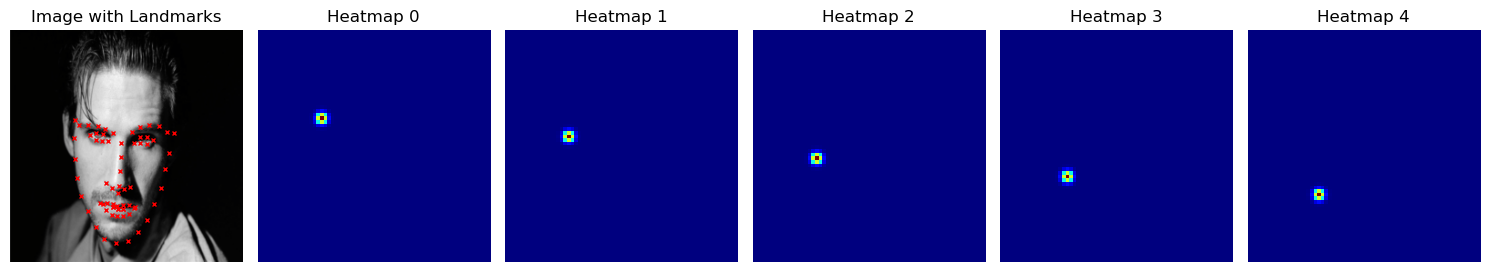

In [26]:
import os
import glob
import numpy as np
import torch
import torch.multiprocessing as mp
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Fix multiprocessing issue on Windows
if os.name == 'nt':
    # Use 'spawn' instead of default 'fork' method
    mp.set_start_method('spawn', force=True)

class FacialLandmarkDataset300W(Dataset):
    """
    Dataset class for 300W facial landmark detection dataset with Indoor/Outdoor structure.
    """
    def __init__(self, root_dir, subset='train', transform=None, heatmap_size=64, sigma=1.0, split_ratio=0.8):
        """
        Initialize the dataset.
        
        Args:
            root_dir: Root directory of the 300W dataset
            subset: 'train' or 'test'
            transform: Transforms to apply to images
            heatmap_size: Size of the output heatmap
            sigma: Sigma for Gaussian heatmap generation
            split_ratio: Ratio for train/test split (applies when using 'train' or 'test')
        """
        self.root_dir = root_dir
        self.subset = subset
        self.transform = transform
        self.heatmap_size = heatmap_size
        self.sigma = sigma
        
        # Get all image paths
        indoor_paths = glob.glob(os.path.join(root_dir, '01_Indoor', '*.png'))
        outdoor_paths = glob.glob(os.path.join(root_dir, '02_Outdoor', '*.png'))
        
        # Combine all paths
        all_image_paths = indoor_paths + outdoor_paths
        
        # Sort for reproducibility
        all_image_paths.sort()
        
        # Split for train/test
        if subset == 'train':
            split_idx = int(len(all_image_paths) * split_ratio)
            self.image_paths = all_image_paths[:split_idx]
        elif subset == 'test':
            split_idx = int(len(all_image_paths) * split_ratio)
            self.image_paths = all_image_paths[split_idx:]
        else:
            raise ValueError(f"Invalid subset: {subset}. Use 'train' or 'test'.")
        
        print(f"Found {len(self.image_paths)} images for {subset} subset")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        
        # Load image
        image = Image.open(image_path).convert('RGB')
        
        # Load landmarks (.pts file)
        pts_path = image_path.replace('.png', '.pts')
        if not os.path.exists(pts_path):
            pts_path = image_path.replace('.jpg', '.pts')
        
        # Parse .pts file
        with open(pts_path, 'r') as f:
            lines = f.readlines()
            landmarks = []
            start_idx = 0
            end_idx = len(lines)
            
            # Find where landmark coordinates start and end
            for i, line in enumerate(lines):
                if "points {" in line or "{" in line:
                    start_idx = i + 1
                if "}" in line:
                    end_idx = i
                    break
            
            for line in lines[start_idx:end_idx]:
                if line.strip():
                    x, y = map(float, line.strip().split())
                    landmarks.append([x, y])
        
        landmarks = np.array(landmarks, dtype=np.float32)
        
        # Get image dimensions
        width, height = image.size
        
        # Apply transformations to image and landmarks
        if self.transform:
            # Create a sample dictionary
            sample = {'image': image, 'landmarks': landmarks}
            sample = self.transform(sample)
            image = sample['image']
            landmarks = sample['landmarks']
        else:
            # Default normalization
            image = transforms.ToTensor()(image)
            image = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])(image)
            
            # Normalize landmarks to [0, 1]
            landmarks[:, 0] /= width
            landmarks[:, 1] /= height
        
        # Generate heatmaps
        heatmaps = self.generate_heatmaps(landmarks, width, height)
        
        # Return image, heatmaps, and landmarks
        return image, heatmaps, landmarks
    
    def generate_heatmaps(self, landmarks, width, height):
        """
        Generate Gaussian heatmaps for landmarks.
        
        Args:
            landmarks: Landmark coordinates [num_landmarks, 2]
            width: Original image width
            height: Original image height
            
        Returns:
            Heatmaps tensor [num_landmarks, heatmap_size, heatmap_size]
        """
        num_landmarks = landmarks.shape[0]
        heatmaps = torch.zeros((num_landmarks, self.heatmap_size, self.heatmap_size))
        
        try:
            for i in range(num_landmarks):
                # Get x, y coordinates (normalized)
                x, y = landmarks[i]
                
                # Convert to heatmap coordinates
                x_heatmap = int(x * self.heatmap_size)
                y_heatmap = int(y * self.heatmap_size)
                
                # Ensure within bounds
                x_heatmap = max(0, min(x_heatmap, self.heatmap_size - 1))
                y_heatmap = max(0, min(y_heatmap, self.heatmap_size - 1))
                
                # Create meshgrid for Gaussian - fix coordinate ordering for clarity
                yy, xx = torch.meshgrid(
                    torch.arange(self.heatmap_size, dtype=torch.float32),
                    torch.arange(self.heatmap_size, dtype=torch.float32),
                    indexing='ij'
                )
                
                # Calculate Gaussian
                gaussian = torch.exp(-((yy - y_heatmap)**2 + (xx - x_heatmap)**2) / (2 * self.sigma**2))
                
                # Assign to heatmap
                heatmaps[i] = gaussian
        except Exception as e:
            print(f"Error generating heatmaps: {e}")
        
        return heatmaps


class FaceLandmarkNormalization:
    """
    Transform to normalize face images and landmarks.
    """
    def __init__(self, output_size=(256, 256)):
        self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        # Get image dimensions
        width, height = image.size
        
        # Resize image
        image = image.resize(self.output_size, Image.BILINEAR)
        
        # Scale landmarks to new size
        scale_x = self.output_size[0] / width
        scale_y = self.output_size[1] / height
        
        landmarks[:, 0] = landmarks[:, 0] * scale_x
        landmarks[:, 1] = landmarks[:, 1] * scale_y
        
        # Normalize landmarks to [0, 1]
        landmarks[:, 0] /= self.output_size[0]
        landmarks[:, 1] /= self.output_size[1]
        
        # Convert image to tensor and normalize
        image = transforms.ToTensor()(image)
        image = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )(image)
        
        return {'image': image, 'landmarks': landmarks}


def prepare_300w_dataset(root_dir, batch_size=32, heatmap_size=64, sigma=1.0, split_ratio=0.8):
    # Data transforms
    transform = FaceLandmarkNormalization(output_size=(256, 256))
    
    # Create datasets
    train_dataset = FacialLandmarkDataset300W(
        root_dir=root_dir,
        subset='train',
        transform=transform,
        heatmap_size=heatmap_size,
        sigma=sigma,
        split_ratio=split_ratio
    )
    
    test_dataset = FacialLandmarkDataset300W(
        root_dir=root_dir,
        subset='test',
        transform=transform,
        heatmap_size=heatmap_size,
        sigma=sigma,
        split_ratio=split_ratio
    )
    
    # Create data loaders with reduced worker count to avoid multiprocessing issues
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,  # Changed from 4 to 0 to avoid worker crashes
        pin_memory=False  # Changed to False to avoid potential memory issues
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,  # Changed from 4 to 0 to avoid worker crashes
        pin_memory=False  # Changed to False to avoid potential memory issues
    )
    
    return train_loader, test_loader


def visualize_sample(image, heatmaps, landmarks, num_landmarks_to_show=5):
    # Denormalize image
    image_np = image.numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)
    
    # Get image dimensions
    height, width = image_np.shape[:2]
    
    # Create figure
    fig = plt.figure(figsize=(15, 10))
    
    # Plot image with landmarks
    ax = fig.add_subplot(1, num_landmarks_to_show + 1, 1)
    ax.imshow(image_np)
    
    # Denormalize landmarks
    landmarks_denorm = landmarks.clone()
    landmarks_denorm[:, 0] *= width
    landmarks_denorm[:, 1] *= height
    
    # Plot landmarks
    ax.plot(landmarks_denorm[:, 0], landmarks_denorm[:, 1], 'rx', markersize=3)
    ax.set_title('Image with Landmarks')
    ax.axis('off')
    
    # Plot selected heatmaps
    for i in range(min(num_landmarks_to_show, len(heatmaps))):
        ax = fig.add_subplot(1, num_landmarks_to_show + 1, i + 2)
        ax.imshow(heatmaps[i], cmap='jet')
        ax.set_title(f'Heatmap {i}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Set 300W dataset root directory
    root_dir = "C:/Users/nguye/OneDrive/Tài liệu/GitHub/AdaptiveWingLoss/300W"  # Update this to your dataset path
    
    train_loader, test_loader = prepare_300w_dataset(
        root_dir=root_dir, 
        batch_size=4,
        split_ratio=0.8  # 80% train, 20% test
    )
    
    # Check dataset sizes
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Testing samples: {len(test_loader.dataset)}")

    # Get a sample batch
    for images, heatmaps, landmarks in train_loader:
        print(f"Image batch shape: {images.shape}")
        print(f"Heatmap batch shape: {heatmaps.shape}")
        print(f"Landmarks batch shape: {landmarks.shape}")
        
        # Visualize first sample in batch
        visualize_sample(images[0], heatmaps[0], landmarks[0])
        break

2025-03-22 01:47:27,310 - INFO - Using device: cpu
2025-03-22 01:47:27,359 - INFO - Loaded 480 train samples
2025-03-22 01:47:27,368 - INFO - Loaded 120 val samples
2025-03-22 01:47:27,370 - INFO - Starting training...
2025-03-22 01:50:17,130 - INFO - Epoch 1/50 | Train Loss: 2.3960 | Val Loss: 2.1112 | NME: 4.4665 | FR: 1.0000 | AUC: 0.0000
2025-03-22 01:52:46,845 - INFO - Epoch 2/50 | Train Loss: 1.4358 | Val Loss: 1.0813 | NME: 5.1107 | FR: 1.0000 | AUC: 0.0000
2025-03-22 01:55:05,900 - INFO - Epoch 3/50 | Train Loss: 0.7559 | Val Loss: 0.6373 | NME: 4.5218 | FR: 1.0000 | AUC: 0.0000
2025-03-22 01:57:27,315 - INFO - Epoch 4/50 | Train Loss: 0.4023 | Val Loss: 0.3233 | NME: 4.4607 | FR: 1.0000 | AUC: 0.0000
2025-03-22 01:59:48,531 - INFO - Epoch 5/50 | Train Loss: 0.2425 | Val Loss: 0.1959 | NME: 4.0278 | FR: 1.0000 | AUC: 0.0000
2025-03-22 02:02:09,894 - INFO - Epoch 6/50 | Train Loss: 0.1676 | Val Loss: 0.1493 | NME: 3.9300 | FR: 1.0000 | AUC: 0.0000
2025-03-22 02:04:31,298 - INFO 

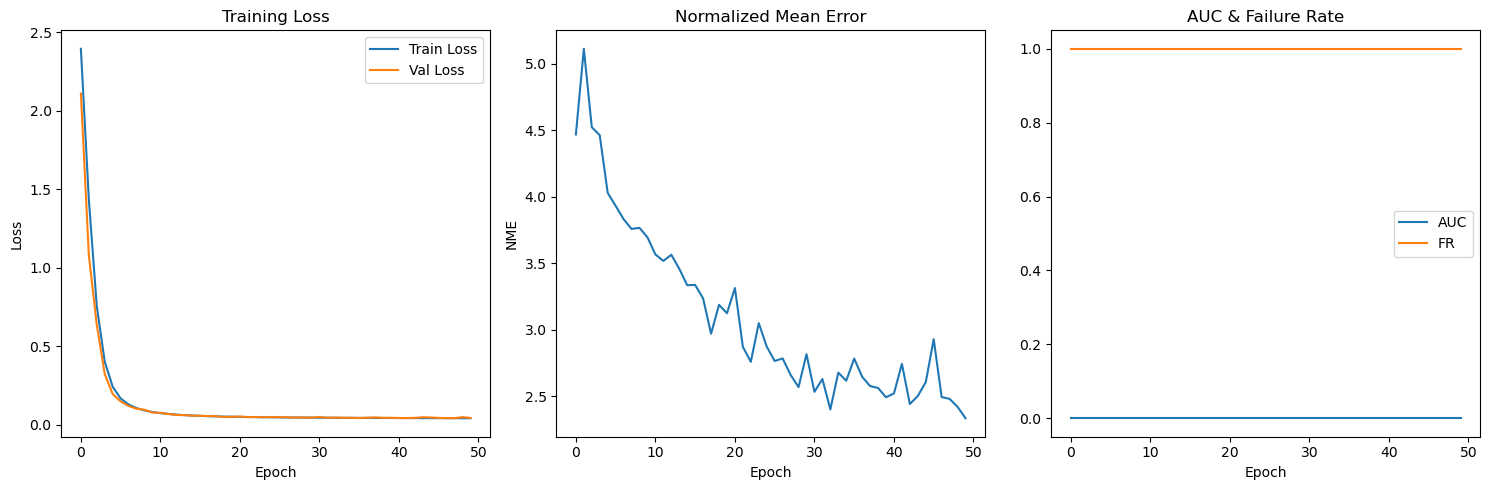

<All keys matched successfully>

In [32]:
# Facial Landmark Detection with Adaptive Wing Loss
# Full Implementation with Evaluation Metrics

# %% [markdown]
# ## Step 1: Environment Setup
#!pip install torch torchvision numpy scikit-learn matplotlib

# %% [markdown]
# ## Step 2: Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import os
import logging
import glob
from PIL import Image
from sklearn.metrics import auc
import matplotlib.pyplot as plt

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# %% [markdown]
# ## Step 3: Dataset Implementation
class FacialLandmarkDataset300W(Dataset):
    """300W dataset with adaptive heatmap generation"""
    def __init__(self, root_dir, subset='train', transform=None, 
                 heatmap_size=64, sigma=2.0, split_ratio=0.8):
        self.root_dir = root_dir
        self.subset = subset
        self.transform = transform
        self.heatmap_size = heatmap_size
        self.sigma = sigma
        
        # Collect and split paths
        paths = sorted(glob.glob(os.path.join(root_dir, '**/*.png')), 
                       key=lambda x: os.path.basename(x))
        split_idx = int(len(paths) * split_ratio)
        self.paths = paths[:split_idx] if subset == 'train' else paths[split_idx:]
        
        logger.info(f"Loaded {len(self.paths)} {subset} samples")

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        # Load image and landmarks
        img_path = self.paths[idx]
        image = Image.open(img_path).convert('RGB')
        pts_path = img_path.replace('.png', '.pts')
        
        # Parse landmarks
        with open(pts_path, 'r') as f:
            lines = [line.strip() for line in f if line.strip()]
            landmarks = np.array([list(map(float, line.split())) 
                                for line in lines[3:-1]], dtype=np.float32)
        
        # Store original dimensions for normalization
        w, h = image.size
        
        # Apply transforms to image
        if self.transform:
            image = self.transform(image)  # This already includes ToTensor()
            # Normalize landmarks to [0, 1]
            landmarks[:, 0] /= float(w)  # Normalize to [0, 1]
            landmarks[:, 1] /= float(h)
        
        # Generate heatmaps
        heatmaps = self._generate_gaussian_heatmaps(landmarks)
        return {
            'image': image,  # Already a tensor from transform
            'heatmaps': torch.from_numpy(heatmaps),
            'landmarks': torch.from_numpy(landmarks)
        }

    def _generate_gaussian_heatmaps(self, landmarks):
        """Generate Gaussian heatmaps for all landmarks"""
        num_landmarks = landmarks.shape[0]
        heatmaps = np.zeros((num_landmarks, self.heatmap_size, self.heatmap_size))
        
        for i, (x, y) in enumerate(landmarks):
            x = x * self.heatmap_size
            y = y * self.heatmap_size
            xx, yy = np.meshgrid(np.arange(self.heatmap_size), np.arange(self.heatmap_size))
            heatmap = np.exp(-((xx - x)**2 + (yy - y)**2) / (2 * self.sigma**2))
            heatmaps[i] = heatmap / heatmap.max()
            
        return heatmaps

# %% [markdown]
# ## Step 4: Model Architecture
class LandmarkDetectionModel(nn.Module):
    """CNN with hourglass-style architecture"""
    def __init__(self, num_landmarks=68, heatmap_size=64):
        super().__init__()
        self.heatmap_size = heatmap_size
        self.base = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(size=(heatmap_size//4, heatmap_size//4)),
            
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(size=(heatmap_size//2, heatmap_size//2)),
            
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(size=(heatmap_size, heatmap_size)),
            
            nn.Conv2d(64, num_landmarks, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.base(x)
        return self.decoder(x)

# %% [markdown]
# ## Step 5: Adaptive Wing Loss
class AdaptiveWingLoss(nn.Module):
    """Implementation of Adaptive Wing Loss for heatmap regression"""
    def __init__(self, alpha=2.1, omega=14, epsilon=1, theta=0.5):
        super().__init__()
        self.alpha = alpha
        self.omega = omega
        self.epsilon = epsilon
        self.theta = theta

    def forward(self, pred, target):
        A = self.omega * (1/(1+(self.theta/self.epsilon)**(self.alpha-target))) * \
            (self.alpha-target)*((self.theta/self.epsilon)**(self.alpha-target-1))/self.epsilon
        C = self.theta*A - self.omega*torch.log(1+(self.theta/self.epsilon)**(self.alpha-target))
        
        loss = torch.where(
            torch.abs(target - pred) < self.theta,
            self.omega*torch.log(1+torch.abs((target - pred)/self.epsilon)**(self.alpha-target)),
            A*torch.abs(target - pred) - C
        )
        return loss.mean()

# %% [markdown]
# ## Step 6: Evaluation Metrics
class LandmarkEvaluator:
    """Calculate NME, FR, and AUC metrics"""
    @staticmethod
    def heatmap_to_coord(heatmaps):
        """Convert heatmaps to landmark coordinates"""
        batch_size, num_landmarks, h, w = heatmaps.shape
        coords = torch.zeros((batch_size, num_landmarks, 2))
        
        for b in range(batch_size):
            for l in range(num_landmarks):
                max_idx = torch.argmax(heatmaps[b, l].view(-1))
                y = max_idx // w
                x = max_idx % w
                coords[b, l] = torch.tensor([x, y], dtype=torch.float32)
        return coords

    @staticmethod
    def calculate_nme(pred_coords, gt_coords, interocular_dist):
        """Normalized Mean Error"""
        errors = torch.norm(pred_coords - gt_coords, dim=2)  # [B, L]
        nme_per_sample = errors.mean(dim=1) / interocular_dist
        return nme_per_sample.mean().item()

    @staticmethod
    def calculate_fr(nme_values, threshold=0.1):
        """Failure Rate"""
        return (np.array(nme_values) > threshold).mean()

    @staticmethod
    def calculate_auc(nme_values, max_threshold=0.1, num_points=100):
        """Area Under Curve"""
        thresholds = np.linspace(0, max_threshold, num_points)
        accuracies = [np.mean(nme_values <= t) for t in thresholds]
        return auc(thresholds, accuracies)

# %% [markdown]
# ## Step 7: Training Pipeline
class Trainer:
    def __init__(self, config):
        self.config = config
        # More robust CUDA detection
        self.device = self._get_device()
        logger.info(f"Using device: {self.device}")
        
        # Initialize components
        self.model = LandmarkDetectionModel(heatmap_size=config['heatmap_size']).to(self.device)
        self.loss_fn = AdaptiveWingLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=config['lr'])
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min')
        
        # Prepare data
        self.train_loader, self.val_loader = self._prepare_dataloaders()
        
        # Tracking
        self.best_val_loss = float('inf')
        self.history = {'train_loss': [], 'val_loss': [], 'nme': [], 'fr': [], 'auc': []}
    
    def _get_device(self):
        """More robust device detection that handles CUDA errors"""
        if not torch.cuda.is_available():
            return torch.device('cpu')
        
        try:
            # Test CUDA device
            device = torch.device('cuda')
            # Create a small tensor to test if CUDA works
            test_tensor = torch.zeros(1).to(device)
            # If we get here, CUDA is working
            return device
        except Exception as e:
            logger.warning(f"CUDA error: {e}")
            logger.warning("Falling back to CPU")
            return torch.device('cpu')

    def _prepare_dataloaders(self):
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        
        train_set = FacialLandmarkDataset300W(
            self.config['data_path'], 'train', transform,
            heatmap_size=self.config['heatmap_size'])
        
        val_set = FacialLandmarkDataset300W(
            self.config['data_path'], 'val', transform,
            heatmap_size=self.config['heatmap_size'])
        
        return (
            DataLoader(train_set, batch_size=self.config['batch_size'], shuffle=True),
            DataLoader(val_set, batch_size=self.config['batch_size'])
        )

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        
        for batch in self.train_loader:
            images = batch['image'].to(self.device)
            heatmaps = batch['heatmaps'].to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.loss_fn(outputs, heatmaps)
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(self.train_loader)
        self.history['train_loss'].append(avg_loss)
        return avg_loss

    def validate(self):
        self.model.eval()
        total_loss = 0
        nme_values = []
        
        with torch.no_grad():
            for batch in self.val_loader:
                images = batch['image'].to(self.device)
                heatmaps = batch['heatmaps'].to(self.device)
                landmarks = batch['landmarks'].to(self.device)
                
                outputs = self.model(images)
                loss = self.loss_fn(outputs, heatmaps)
                total_loss += loss.item()
                
                # Convert to coordinates
                pred_coords = LandmarkEvaluator.heatmap_to_coord(outputs)
                gt_coords = landmarks * self.config['heatmap_size']
                
                # Calculate interocular distance
                left_eye = gt_coords[:, 36]
                right_eye = gt_coords[:, 45]
                interocular = torch.norm(left_eye - right_eye, dim=1)
                
                # Calculate NME
                nme = LandmarkEvaluator.calculate_nme(pred_coords, gt_coords, interocular.mean())
                nme_values.append(nme)
        
        avg_loss = total_loss / len(self.val_loader)
        avg_nme = np.mean(nme_values)
        fr = LandmarkEvaluator.calculate_fr(nme_values)
        auc = LandmarkEvaluator.calculate_auc(nme_values)
        
        # Update history
        self.history['val_loss'].append(avg_loss)
        self.history['nme'].append(avg_nme)
        self.history['fr'].append(fr)
        self.history['auc'].append(auc)
        
        # Update scheduler
        self.scheduler.step(avg_loss)
        
        # Save best model
        if avg_loss < self.best_val_loss:
            self.best_val_loss = avg_loss
            torch.save(self.model.state_dict(), os.path.join(self.config['save_dir'], 'best_model.pth'))
        
        return avg_loss, avg_nme, fr, auc

    def train(self):
        logger.info("Starting training...")
        for epoch in range(self.config['epochs']):
            train_loss = self.train_epoch()
            val_loss, nme, fr, auc = self.validate()
            
            logger.info(
                f"Epoch {epoch+1}/{self.config['epochs']} | "
                f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
                f"NME: {nme:.4f} | FR: {fr:.4f} | AUC: {auc:.4f}"
            )

# %% [markdown]
# ## Step 8: Configuration & Execution
config = {
    'data_path': '300W',
    'heatmap_size': 64,
    'batch_size': 32,
    'lr': 1e-3,
    'epochs': 50,
    'save_dir': 'checkpoints'
}

# Create save directory
os.makedirs(config['save_dir'], exist_ok=True)

# Initialize and run training
trainer = Trainer(config)
trainer.train()

# %% [markdown]
# ## Step 9: Visualization
def plot_training_history(history):
    plt.figure(figsize=(15, 5))
    
    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # NME plot
    plt.subplot(1, 3, 2)
    plt.plot(history['nme'], label='NME')
    plt.title('Normalized Mean Error')
    plt.xlabel('Epoch')
    plt.ylabel('NME')
    
    # AUC/FR plot
    plt.subplot(1, 3, 3)
    plt.plot(history['auc'], label='AUC')
    plt.plot(history['fr'], label='FR')
    plt.title('AUC & Failure Rate')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(trainer.history)

# %% [markdown]
# ## Step 10: Inference Example
def visualize_prediction(model, dataset, device):
    sample = dataset[np.random.randint(len(dataset))]
    image = sample['image'].unsqueeze(0).to(device)
    
    with torch.no_grad():
        heatmaps = model(image)
        pred_coords = LandmarkEvaluator.heatmap_to_coord(heatmaps)[0].cpu()
    
    gt_coords = sample['landmarks'] * dataset.heatmap_size
    
    plt.figure(figsize=(10, 5))
    plt.imshow(image[0].cpu().permute(1, 2, 0))
    
    # Plot predictions
    plt.scatter(pred_coords[:, 0], pred_coords[:, 1], 
                c='red', s=10, label='Predicted')
    # Plot ground truth
    plt.scatter(gt_coords[:, 0], gt_coords[:, 1], 
                c='green', s=10, label='Ground Truth')
    
    plt.legend()
    plt.title("Landmark Prediction Visualization")
    plt.axis('off')
    plt.show()

# Load best model
best_model = LandmarkDetectionModel().to(trainer.device)
best_model.load_state_dict(torch.load('checkpoints/best_model.pth'))